In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import *
from tqdm import tqdm
from numba import njit
import random
from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.dpi"] = 100
plt.set_cmap("binary_r")

<Figure size 1400x800 with 0 Axes>

# Boids model
Consider a flock of birds. If they are located in a too dense area, then they want to repell each other. 
At some intermediate distance, for example in a distance where they can see. each other, then birds will get attracted to each other and move in the same direction. In the same time, the flock will also try to cluster to the center of mass. The behvaior can be summarized as:
1. Separation
2. Alignment 
3. Cohesion

In [47]:
np.random.seed(42)

# Simulation parameters
r1, r2, r3 = 1, 5, 10
N = 100  # Number of particles
x1, x2 = -10, 10
v1, v2 = -1, 1
rho1, rho2, rho3, rho4 = [0.1, 0.6, 0.1, 0.2]
eta = 0.5 * np.pi  # random factor upper bound (in radians)

# Animation constants 
time_steps = 5000
factor = 50 
frames = time_steps // factor
dt = 1e2 / time_steps


position_history = np.zeros([frames, N, 2])
xy = np.random.uniform(x1, x2, [N, 2])  # Particle positions
v  = np.random.uniform(v1, v2, [N, 2])  # Particle velocities

# Function for computing the pair wise distances of the particles.
@njit
def get_distances(xy):
    N = len(xy)
    separation = np.zeros((N, N, 2))
    for i in range(N):
        for j in range(N):
            separation[i, j] = xy[i] - xy[j]
    pair_wise_distance = np.sqrt(np.sum(separation**2, axis=-1))
    return pair_wise_distance


def theta1(xy):
    center_of_mass = np.mean(xy, axis=0) 
    repulsion_vectors = xy - center_of_mass
    theta = np.arctan2(repulsion_vectors[:, 1], repulsion_vectors[:, 0])
    return theta

@njit
def theta2(xy, v, i, alignment_indices):
    # find indices of neighboring particles within radius r2
    neighbors_indices = alignment_indices[i]
    # get velocities of neighboring particles
    neighbors_v = v[neighbors_indices] 
    # calculate angles of velocities
    neighbors_theta = np.arctan2(neighbors_v[:, 1], neighbors_v[:, 0])
    # calculate mean direction angle
    mean_direction = np.arctan2(np.sum(np.sin(neighbors_theta)), np.sum(np.cos(neighbors_theta)))
    return mean_direction


def theta3(xy):
    center_of_mass = np.mean(xy, axis=0) 
    attraction_vectors = center_of_mass - xy
    theta = np.arctan2(attraction_vectors[:, 1], attraction_vectors[:, 0])
    return theta


# Function for updating the velocity vector for each particle
def update_vector(repelling_angles, theta2_value, attracting_angles, prev_direction):
    
    # Function for converting from angle to directional vector
    def directional_vector(theta):
        if isinstance(theta, (float, np.float32, np.float64)):
            u = np.array([np.cos(theta), np.sin(theta)])
        else: 
            u = np.array([np.cos(theta), np.sin(theta)]).T
        return u

    # If there are no particles in all three zones, return previous direction randomly perturbed
    if repelling_angles.size == 0 and np.isnan(theta2_value) and attracting_angles.size == 0:
        alpha, beta = 0.6, 0.4  # example weights for previous direction and random factor
        return alpha * prev_direction + beta * directional_vector(np.random.uniform(-eta, eta))
    
    # Computing the unit directional vector based on the angle.
    # The else statements handles the special case where there is no repelling/attracting particles,
    # in that case the directional vector is zero, i.e., no updating.
    e1 = np.mean(directional_vector(repelling_angles), axis=0) if repelling_angles.size > 0 else np.array([0.0, 0.0])
    e2 = directional_vector(theta2_value) if not np.isnan(theta2_value) else np.array([0.0, 0.0])
    e3 = np.mean(directional_vector(attracting_angles), axis=0) if attracting_angles.size > 0 else np.array([0.0, 0.0])
    e4 = directional_vector(np.random.uniform(-eta, eta))
    
    weighted_vector = rho1 * e1 + rho2 * e2 + rho3 * e3 + rho4 * e4
    return weighted_vector


f = 0
for t in tqdm(range(time_steps)):
    if t % factor == 0:
        position_history[f] = xy
        f += 1

    distance = get_distances(xy)

    repelling_indices  = (distance != 0)  * (distance < r1)
    alignment_indices  = (distance >= r1) * (distance < r2)
    attracting_indices = (distance >= r2) * (distance < r3)

    theta1_values = theta1(xy)
    theta3_values = theta3(xy)

    # Update velocities
    for i in range(N):
        theta2_value  = theta2(xy, v, i, alignment_indices) if np.any(alignment_indices[i]) else np.nan
        repelling_angles = theta1_values[repelling_indices[i]]
        attracting_angles = theta3_values[attracting_indices[i]]

        # Update vector
        v[i] = update_vector(repelling_angles, theta2_value, attracting_angles, v[i])

    # Update positions
    xy += v * dt

100%|██████████| 5000/5000 [00:49<00:00, 102.00it/s]


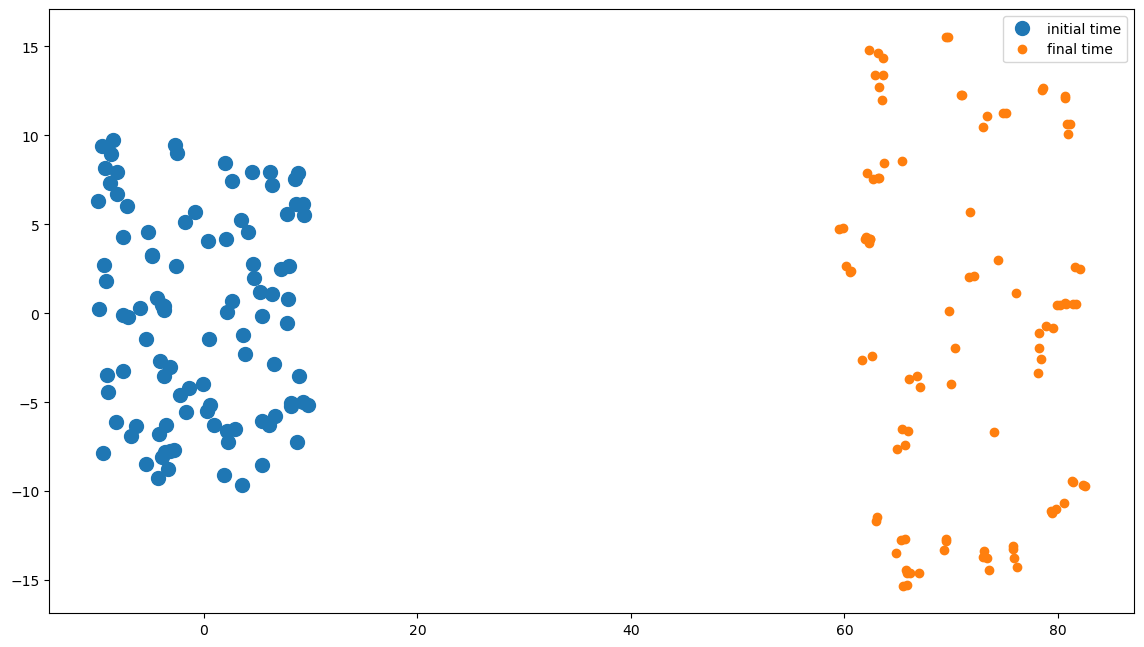

In [48]:
# Plotting the first and last frame of the simulation
position_history = np.array(position_history)
plt.plot(*position_history[0].T, "o", ms=10, label="initial time")
plt.plot(*position_history[-1].T, "o", label="final time")
plt.legend()

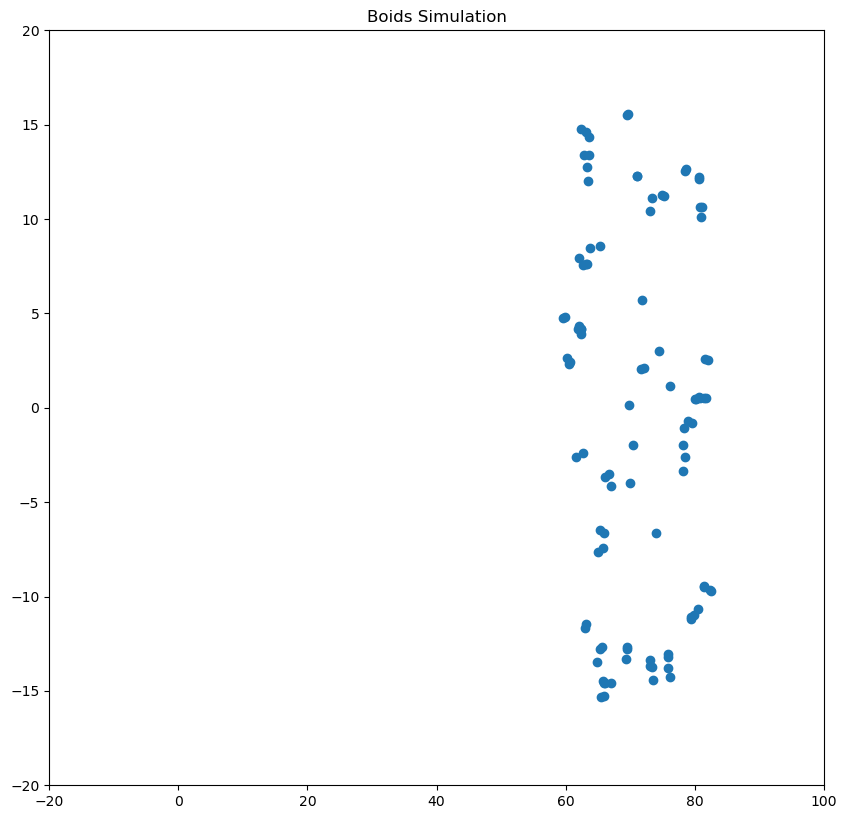

In [49]:
def plot_animation(simulation_data):
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

    def update(frame):
        ax.clear()
        ax.set_xlim(frames*dt*x1, 5*frames*dt*x2)
        ax.set_ylim(frames*dt*x1, frames*dt*x2)
        ax.scatter(*simulation_data[frame].T)
        ax.set_title('Boids Simulation')

    anim = FuncAnimation(fig, update, frames=len(simulation_data), repeat=False)
    anim.save("boids_simulation.gif", writer="pillow")

plot_animation(position_history)

# Aggregation measure
Entropy can be interpreted as a measure of disorder of a system.
An ordered system, such as an ice cube have a low entropy since the water-molecules are ordered in a regular way (crystal structure).
An unordered system would be the melted ice cube. The order of the water-molecules are less ordered because they are not bounded to each other in a crystal structure. The water pool thus have a higher entropy than the ice cube. \
\
Entropy can be formalized to work on a propability density function $\rho$. A "narrow looking" density function have a lower entropy than a "wide spread". For instance, a Gaussian with standard deviation 1 have lower entropy than a Gaussian with standard deviation 2. 
There are various different entropy formulations, I will use the Shannon entropy as a starting point for the aggregation measure, which is defined as: 
\begin{equation}
    S = -\sum_i \rho_i\log\rho_i.
\end{equation}
However, we want the aggregation measure to be large when the particles are closely gathered which is the opposite behavior of the Shannon entropy. Therefore, I use the negative Shannon entropy as my aggregation measure:
\begin{equation}
    A = -S = \sum_i \rho_i\log\rho_i.
\end{equation}

In [55]:
def compute_entropy(xy, bins=N//50): # Function for computing the Shannon entropy
    hist, _, _ = np.histogram2d(*xy.T, bins=bins, density=True)
    hist = hist[hist > 0]  # remove zero entries
    return -np.sum(hist * np.log(hist)) 

In [56]:
np.random.seed(42)

time_steps = 100
dt = 2e2 / time_steps

def run_simulation(xy, v, r1, r2, r3, rho1, rho2, rho3, rho4, eta):
    for t in range(time_steps):

        distance = get_distances(xy)
        repelling_indices  = (distance != 0)  * (distance < r1)
        alignment_indices  = (distance >= r1) * (distance < r2)
        attracting_indices = (distance >= r2) * (distance < r3)

        theta1_values = theta1(xy)
        theta3_values = theta3(xy)

        # Update velocities
        for i in range(N):
            theta2_value  = theta2(xy, v, i, alignment_indices) if np.any(alignment_indices[i]) else np.nan
            repelling_angles = theta1_values[repelling_indices[i]]
            attracting_angles = theta3_values[attracting_indices[i]]

            # Update vector
            v[i] = update_vector(repelling_angles, theta2_value, attracting_angles, v[i])

        # Update positions
        xy += v * dt
    return xy


# Discretize the x-y plane into cells
n_cells = 20  # number of cells along each axis
x_values = np.linspace(0.01, 0.99, n_cells)
y_values = np.linspace(0.01, 0.99, n_cells)

# Create an empty array to store entropy values
entropy_values = np.empty((n_cells, n_cells))

# Iterate over the cells
for i, x in tqdm(enumerate(x_values)):
    for j, y in enumerate(y_values):
        # Ensure that x < y
        if x < y:
            # Compute r1, r2 and r3
            r1 = x
            r2 = y
            r3 = 1  # because x, y < 1 and r1/r3 = x, r2/r3 = y

            # Run simulation with these parameters
            position_last_frame = run_simulation(xy, v, r1, r2, r3, rho1, rho2, rho3, rho4, eta)

            # Compute entropy for final positions
            entropy = compute_entropy(position_last_frame)

            # Store result
            entropy_values[j, i] = entropy
        else:
            entropy_values[j, i] = np.nan  # no valid r1, r2, r3


20it [01:19,  4.00s/it]


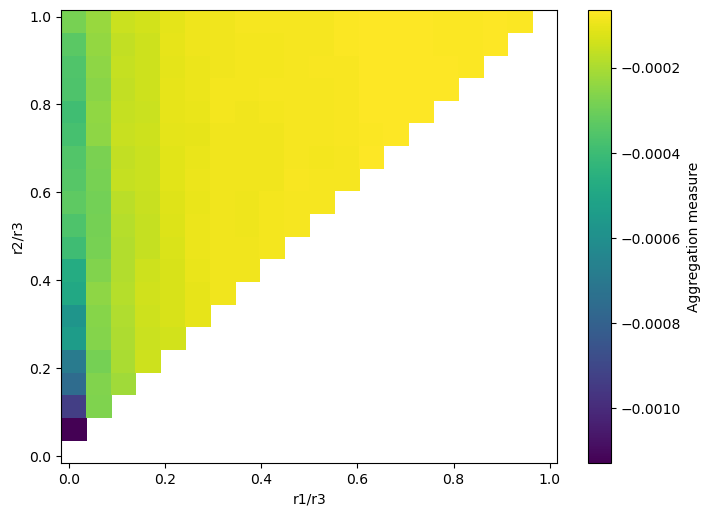

In [57]:
# Create 2D plot
plt.figure(figsize=(8, 6))
plt.pcolormesh(x_values, y_values, -entropy_values, cmap='viridis', shading="auto")
plt.colorbar(label='Aggregation measure')
plt.xlabel('r1/r3')
plt.ylabel('r2/r3')
plt.show()

There seems to be some relatively significant jump in the small regime $r_1/r_3$, this can be seen as phase transition.

100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


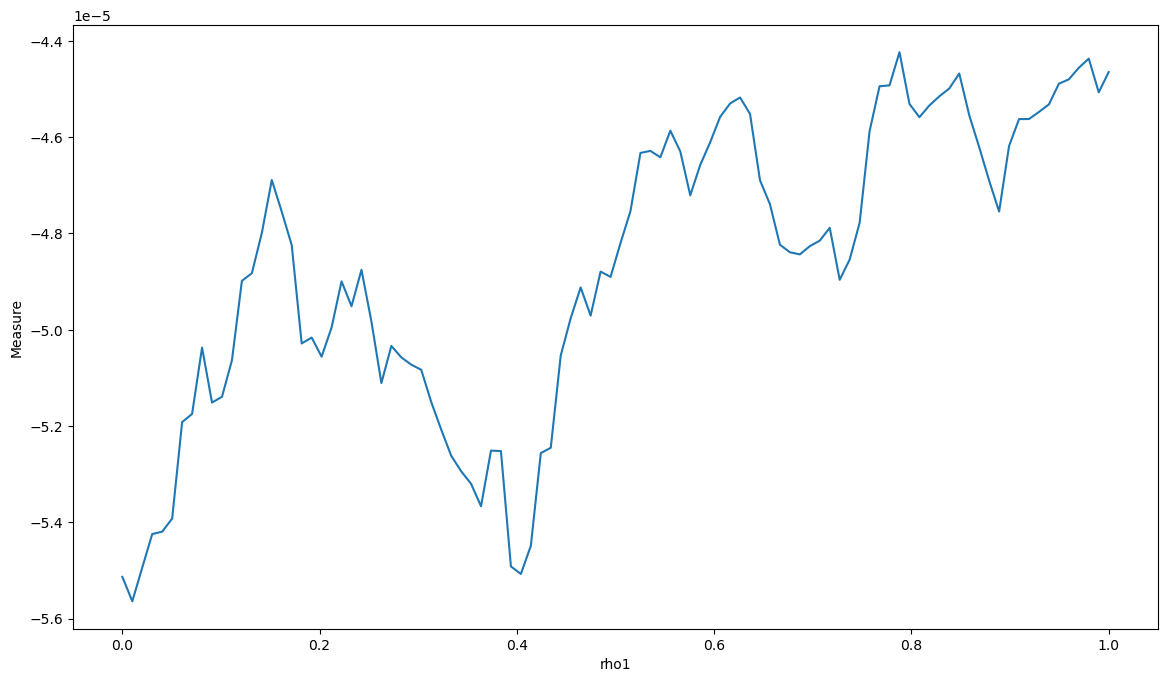

In [59]:
# Array to store measure values
measure_values = []

# Range of values for rho1
rho1_values = np.linspace(0, 1, 100)

# Run simulation for each value of rho1
for rho1 in tqdm(rho1_values):
    position_last_frame = run_simulation(xy, v, r1, r2, r3, rho1, rho2, rho3, rho4, eta)
    measure = -compute_entropy(position_last_frame)
    measure_values.append(measure)

# Plot measure vs rho1
plt.plot(rho1_values, measure_values)
plt.xlabel('rho1')
plt.ylabel('Measure')
plt.show()

100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


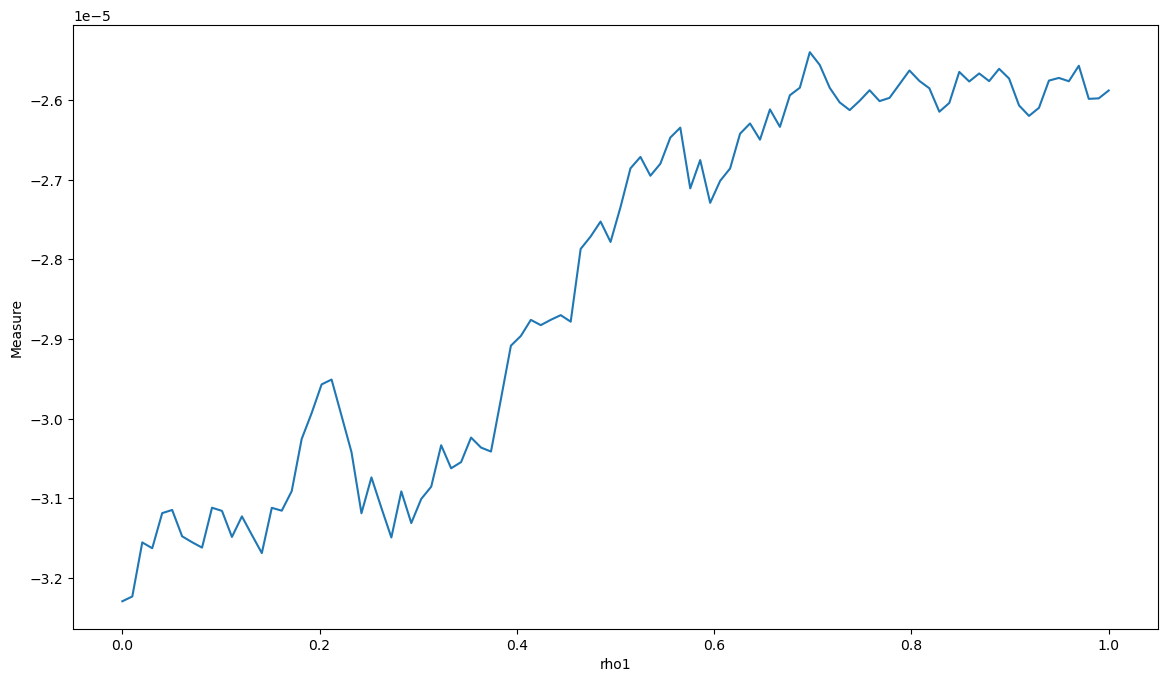

100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


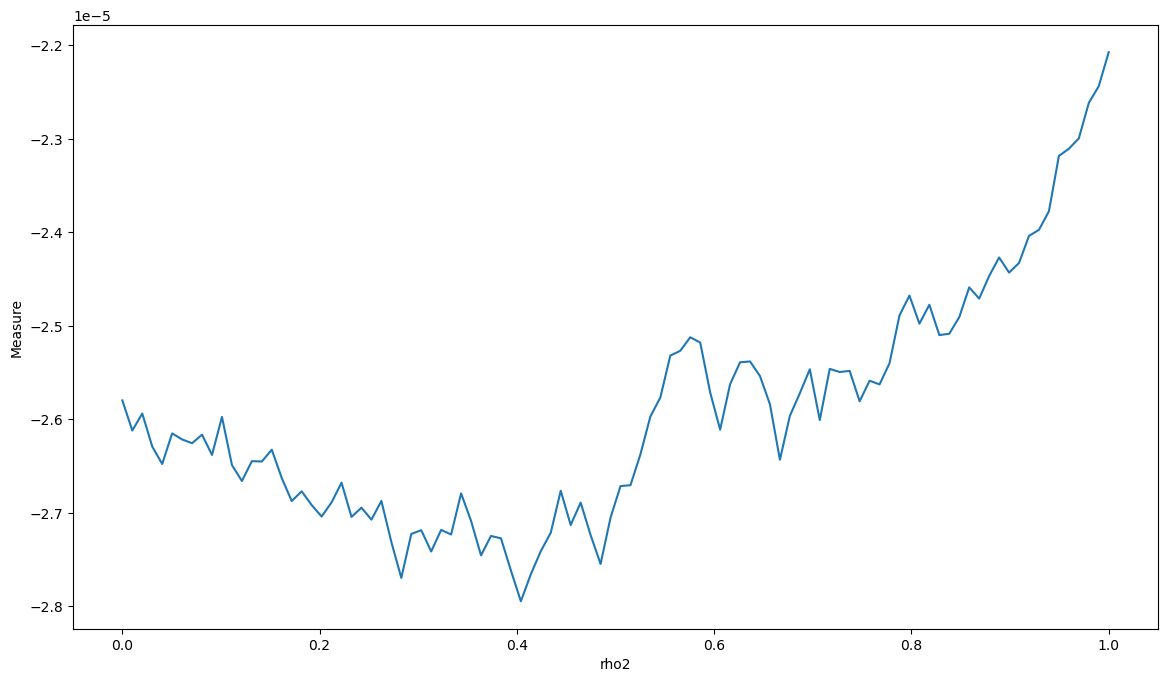

100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


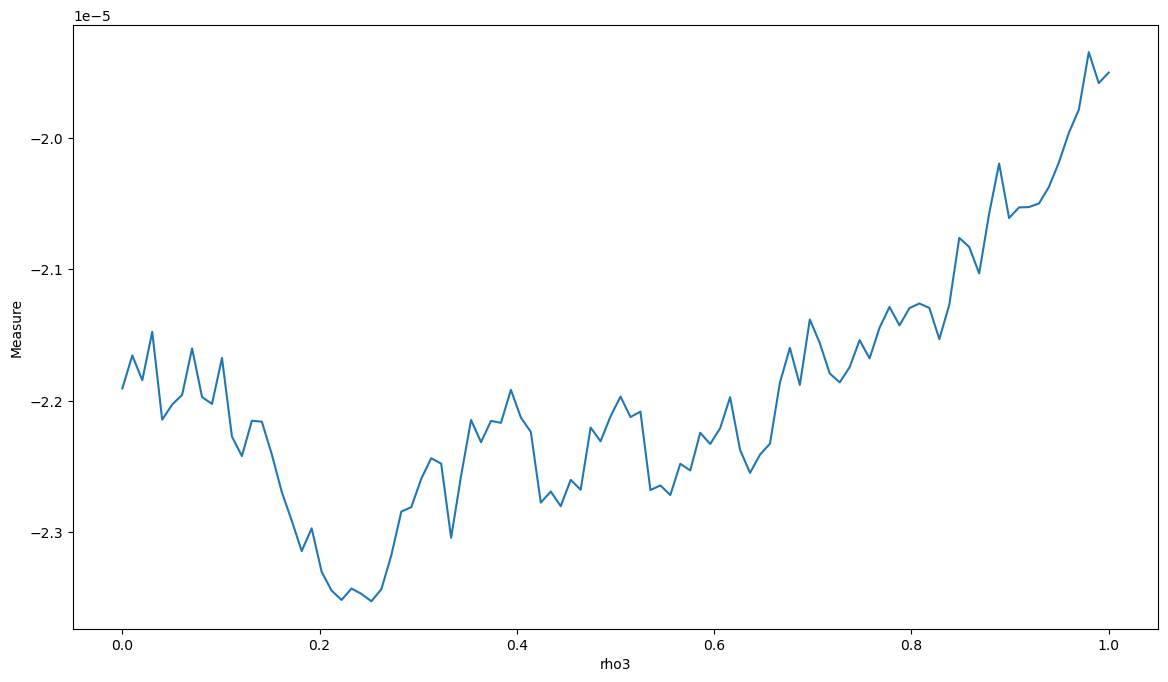

 59%|█████▉    | 59/100 [00:25<00:17,  2.34it/s]

In [ ]:
def run_simulation_and_plot(rho_values, rho_index, fixed_rho_values):
    # Array to store measure values
    measure_values = []

    # Run simulation for each value of rho
    for rho in tqdm(rho_values):
        # Create a copy of the fixed rho values
        current_rho_values = fixed_rho_values.copy()
        # Set the value of the rho we're varying
        current_rho_values[rho_index] = rho
        # Ensure the rho values sum to 1
        current_rho_values /= np.sum(current_rho_values)
        # Run the simulation
        position_last_frame = run_simulation(xy, v, r1, r2, r3, *current_rho_values, eta)
        measure = -compute_entropy(position_last_frame)
        measure_values.append(measure)

    # Plot measure vs rho
    plt.plot(rho_values, measure_values)
    plt.xlabel(f'rho{rho_index + 1}')
    plt.ylabel('Measure')
    plt.show()

# Range of values for each rho
rho_values = np.linspace(0, 1, 100)

# Fixed values for each rho
fixed_rho_values = [0.1, 0.6, 0.1, 0.2]

# Run the function for each rho
for i in range(4):
    run_simulation_and_plot(rho_values, i, fixed_rho_values)